In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.stats import multivariate_normal, mode
from tqdm import trange, tqdm
from matplotlib import colormaps
import pandas as pd

np.random.seed(42)

In [2]:
# Gaussian Mixture Model Parameters
# Pis
pi = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Means
means = [
    [-10.0, 0.0],
    [0.0, -10.0],
    [10.0, 0.0],
    [0.0, 10.0],
    [-5.0, 4.5],
    [5.0, 4.5],
    [0.0, -0.5],
    [0.0, -7.5],
    [-7.0, -5.5],
    [7.0, -5.5],
]

# Sigmas
covs = [
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[3.0, 0.0], [0.0, 0.1]],
    [[1.0, 0.0], [0.0, 1.0]],
    [[0.1, 0.0], [0.0, 3.0]],
    [[4.0, 0.0], [0.0, 0.1]],
    [[0.5500000000000002, -0.45], [-0.45, 0.5499999999999999]],
    [[0.5500000000000002, 0.45], [0.45, 0.5499999999999999]],
]

In [3]:
# Generate synthetic data from the GMM
def generate_data(n_samples=1000):
    data = []
    labels = []
    for i, (mean, cov) in enumerate(zip(means, covs)):
        n = int(n_samples * pi[i])
        samples = np.random.multivariate_normal(mean, cov, n)
        data.append(samples)
        labels.extend([i] * n)
    return np.vstack(data), np.array(labels)


data, labels = generate_data()

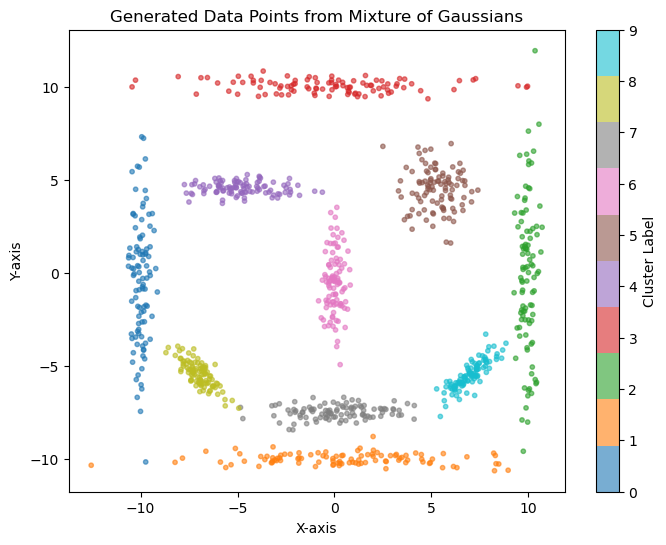

In [4]:
# Visualize the true distribution
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, c=labels, cmap="tab10", s=10)
plt.title("Generated Data Points from Mixture of Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Cluster Label")
#plt.savefig("True_Distribution.png")
plt.show()

Converged after 17 iterations
ARI: 0.71


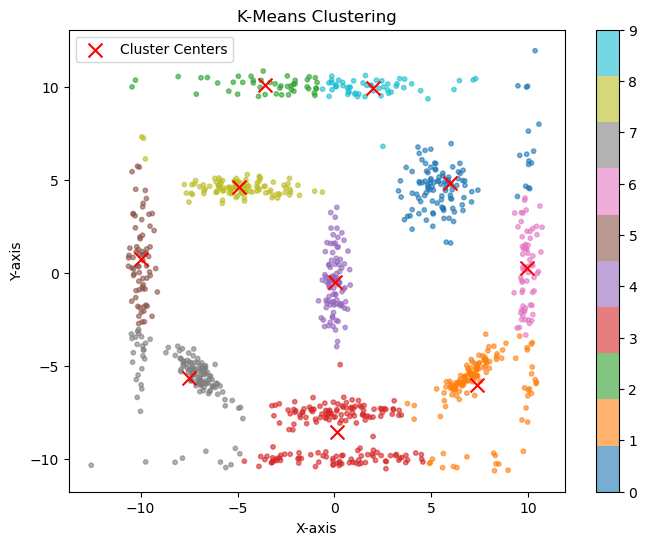

,x_coordinate,y_coordinate
0,5.951235,4.826540
1,7.364381,-6.033339
2,-3.579031,10.077902
3,0.154864,-8.560151
4,0.009340,-0.504018
5,-9.975363,0.722498
6,9.933807,0.245233
7,-7.509269,-5.629124
8,-4.927988,4.609202
9,1.973236,9.929091


In [5]:
# 1. K-Means Clustering
def run_kmeans(data, n_clusters=3, max_iterations=1000):
    # Initialize predictions and centers  
    predictions = np.random.randint(0, n_clusters, size=len(data))
    centers = np.random.rand(n_clusters, data.shape[1])

    # K-means for max iterations or when the centers does not change
    for it in range(max_iterations):

        # Step 1: Predictions
        distances = np.zeros((data.shape[0], n_clusters))
        for c in range(n_clusters):
            distances[:, c] = np.linalg.norm(data - centers[c], axis=1)
        predictions = np.argmin(distances, axis=1)

        # Step 2: Updating cluster center
        new_centers = np.zeros((n_clusters, data.shape[1]))
        for c in range(n_clusters):
            # If no points assigned to a cluster update the center randomly 
            if np.sum(predictions == c) == 0:
                new_centers[c, :] = data[np.random.randint(0, len(data))]
            else:
                new_centers[c, :] = np.mean(data[predictions == c], axis=0)

        #Break if center don't change 
        if np.allclose(centers, new_centers, atol=1e-6):
            break

        centers = new_centers
    return predictions, centers

n_clusters = len(pi)
kmeans_predictions, centers = run_kmeans(data, n_clusters)
print(f"ARI: {adjusted_rand_score(labels, kmeans_predictions):.2f}")


'''
Changed the plotting a bit so it matched the orginal plot of the data so it would be easier to compare
'''

# Create a colormap for the clusters
cmap = colormaps["tab10"].resampled(n_clusters)

# Plot K-Means Results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data[:, 0],
    data[:, 1],
    c=kmeans_predictions,
    cmap=cmap,
    alpha=0.6,
    s=10,
)

plt.scatter(
    centers[:, 0], 
    centers[:, 1], 
    c="red", 
    marker="x", 
    s=100, 
    label="Cluster Centers"
)

cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"{i}" for i in range(n_clusters)])  # Label clusters

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("K-Means Clustering")
plt.legend()
plt.savefig("K-means_clustering")
plt.show()
df_cluster_centers = pd.DataFrame(centers, columns=["x_coordinate", "y_coordinate"])
df_cluster_centers


In [14]:
n_runs = 10
ari_score = []
for _ in range(n_runs):
    kmeans_predictions, _ = run_kmeans(data, n_clusters)
    ari_score.append(adjusted_rand_score(labels, kmeans_predictions))
average = sum(ari_score)/n_runs
print(f"Average ARI score after {n_runs} runs: {average: .2f}")
max_score =np.max(ari_score)
min_score = np.min(ari_score)
print(f"Max: {max_score: .2f}")
print(f"Min: {min_score: .2f}")

Converged after 23 iterations
Converged after 26 iterations
Converged after 18 iterations
Converged after 13 iterations
Converged after 14 iterations
Converged after 13 iterations
Converged after 14 iterations
Converged after 14 iterations
Converged after 17 iterations
Converged after 10 iterations
Average ARI score after 10 runs:  0.70
Max:  0.73
Min:  0.63


In [5]:
# Helper function for gibbs and Metropolis Hastings

# computes P(z[i] = k | x[i])
def compute_posterior(data, mixing_coeff, mean, covariance):
    liklihood = multivariate_normal.pdf(data, mean, covariance)
    return mixing_coeff*liklihood 

def update_cluster_prop(data, cluster_assignments, mixing_coeff, means, covariances, n_clusters):
    n_points, dim = data.shape
    epsilon = 1e-6 

    for k in range(n_clusters):
        points_in_cluster_k = data[cluster_assignments == k]
        if len(points_in_cluster_k) > 0:
            means[k] = np.mean(points_in_cluster_k, axis=0)
            mixing_coeff[k] = len(points_in_cluster_k) / n_points
            covariances[k] = np.matmul(
                (points_in_cluster_k - means[k]).T, 
                (points_in_cluster_k - means[k])
            ) / len(points_in_cluster_k)
        else:
            means[k] = np.zeros(dim)
            mixing_coeff[k] = epsilon
            covariances[k] = np.eye(dim) * epsilon

        covariances[k] += epsilon * np.eye(dim)

    mixing_coeff /= np.sum(mixing_coeff)
    return mixing_coeff, means, covariances


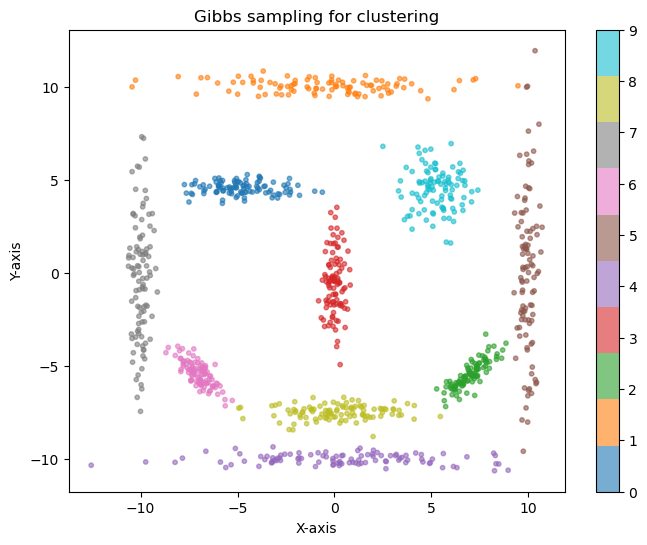

ARI: 0.99


In [34]:
# # 2. Gibbs Sampling for Clustering
    
def gibbs_sampling(data, n_clusters=3, n_samples=500, burn_in=200):
     n_points, dim = data.shape
     cluster_assignments = np.random.choice(n_clusters, n_points)
    

     # Initilize clusters
     means = data[np.random.choice(n_points, n_clusters, replace=False)]
     covariances = np.array([np.eye(dim)] * n_clusters)
     mixing_coeff = np.ones(n_clusters) / n_clusters

     # Gibbs sampling for clustering 
     samples_to_save = np.zeros((n_samples, n_points), dtype=np.int64)
     for sample in range(n_samples+burn_in):
         posterior_probs = np.zeros((n_points, n_clusters))

         # Evaluating the condintional proability 
         for k in range(n_clusters):
            posterior_probs[:, k] = compute_posterior(data, mixing_coeff[k], means[k], covariances[k])

         # Assign new cluster to points with the conditional probability
         posterior_probs /= posterior_probs.sum(axis=1, keepdims=True)
         cluster_assignments = np.array([np.random.choice(n_clusters, p=row) for row in posterior_probs])

         # Update the cluster parameters 
         mixing_coeff, means, covariances = update_cluster_prop(data, cluster_assignments, mixing_coeff, means, covariances, n_clusters)

         # Collect samples after burn-in 
         if sample >= burn_in:
             samples_to_save[sample - burn_in] = cluster_assignments
        
           
     return mode(samples_to_save, axis=0)[0]

n_clusters = len(pi)
gibbs_predictions = gibbs_sampling(data, n_clusters)

'''
Changed the plotting a bit so it matched the orginal plot of the data so it would be easier to compare
'''

cmap = colormaps["tab10"].resampled(n_clusters)

# Plot the scatter points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data[:, 0],
    data[:, 1],
    c=gibbs_predictions,
    cmap=cmap,
    alpha=0.6,
    s=10,
)

cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"{i}" for i in range(n_clusters)])  # Label clusters

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Gibbs sampling for clustering")
#plt.savefig("Gibbs_Sampling_for_clustering.png")
plt.show()

print(f"ARI: {adjusted_rand_score(labels, gibbs_predictions):.2f}")

In [20]:
# Calculate the avergae perfromace after 10 runs 
n_runs = 10
ari_score = []
for _ in range(n_runs):
    gibbs_predictions = gibbs_sampling(data, n_clusters)
    ari_score.append(adjusted_rand_score(labels, gibbs_predictions))
average = sum(ari_score)/n_runs
print(f"Average ARI score after {n_runs} runs: {average:.2f}")
max_score =np.max(ari_score)
min_score = np.min(ari_score)
print(f"Max: {max_score: .2f}")
print(f"Min: {min_score: .2f}")

Average ARI score after 10 runs: 0.84
Max:  0.99
Min:  0.71


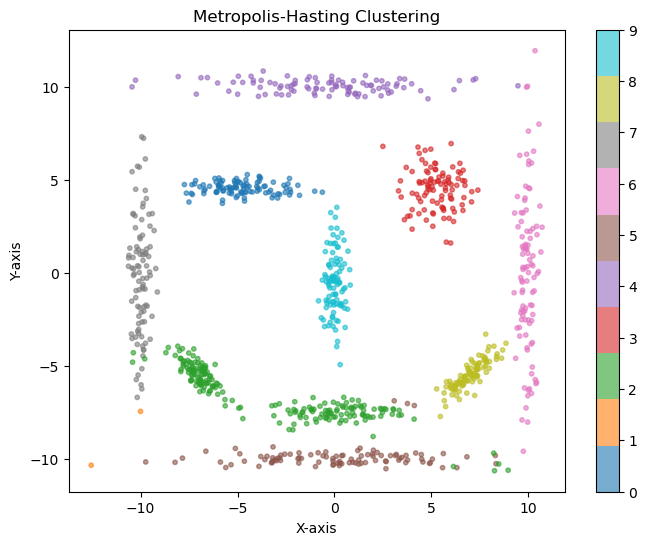

ARI: 0.8596464999558141


In [57]:
# 3. Metropolis-Hastings for Clustering
    
def metropolis_hastings(
    data, n_clusters=3, proposal_var=10, n_samples=500, burn_in=200
):
    # Initilize assignments 
    n_points, dim = data.shape
    cluster_assignments = np.random.choice(n_clusters, n_points)

    # Initilize clusters
    means = data[np.random.choice(n_points, n_clusters, replace=False)]
    covariances = np.array([np.eye(dim)] * n_clusters)
    mixing_coeff = np.ones(n_clusters) / n_clusters

    # Samples to save after burn in
    samples_to_save = np.zeros((n_samples, n_points), dtype=np.int64)

    # Metropolis-Hasting algorithm
    for sample in range(n_samples+burn_in):
        for i in range(n_points):

            # Old assignmnets 
            z = cluster_assignments[i]

            # Propose a new clusster assignmnet for data point i from a normal dist centered at the old assignmnet with some variance 
            #z_prime = int(round(np.random.normal(z, np.sqrt(proposal_var)))) 

            # Optional proposal distribution
            z_prime = np.random.choice(n_clusters)
                
            # Compute the conditional probability for the old and new assignmnet if our proposed assignmnet is between 0 and n_clusters
            if z_prime != z:
                if 0 <= z_prime < n_clusters: 
                    old_posterior = compute_posterior(data[i,:], mixing_coeff[z], means[z], covariances[z])
                    new_posterior = compute_posterior(data[i,:], mixing_coeff[z_prime], means[z_prime], covariances[z_prime])
                    acceptance_prob = min(1, new_posterior/old_posterior)
                # If not reject the sample directly
                else:
                    acceptance_prob = 0 
            
                # Accept the new assignmnet wPr acceptance_prob and reject wPr 1-acceptance_prob
                if np.random.uniform(0, 1) < acceptance_prob:
                    cluster_assignments[i] = z_prime

        # Update cluster paramters 
        mixing_coeff, means, covariances = update_cluster_prop(data, cluster_assignments, mixing_coeff, means, covariances, n_clusters)

        #Collects samples after burn in 
        if sample >= burn_in:
             samples_to_save[sample - burn_in] = cluster_assignments

    return mode(samples_to_save, axis=0)[0]

var = 10
n_clusters = len(pi)
mh_predictions = metropolis_hastings(data, n_clusters, var)

'''
Changed the plotting a bit so it matched the orginal plot of the data so it would be easier to compare
'''

cmap = colormaps["tab10"].resampled(n_clusters)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data[:, 0],
    data[:, 1],
    c=mh_predictions,
    cmap=cmap,
    alpha=0.6,
    s=10,
)

cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"{i}" for i in range(n_clusters)])  # Label clusters

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Metropolis-Hasting Clustering")
#plt.savefig(f"MetroPolis_for_clustering.png")
plt.show()
print(f"ARI: {adjusted_rand_score(labels, mh_predictions)}")

In [28]:
# Calculate the avergae perfromace after 10 runs 
n_runs = 10
proposal_var = [0.01, 0.1, 1, 10]
average_ari_scores = []
for v in proposal_var: 
    ari_score = []
    for _ in range(n_runs):
        mh_predictions = metropolis_hastings(data, n_clusters, v)
        ari_score.append(adjusted_rand_score(labels, mh_predictions))
    average = sum(ari_score)/n_runs
    average_ari_scores.append(average)
    print(f" Variance: {v}, Average ARI: {average}, Max ARI: {np.max(ari_score)}, Min ARI: {np.min(ari_score)} ")

 Variance: 0.01, Average ARI: 0.0008216659787777126, Max ARI: 0.0035190441857072203, Min ARI: -0.0014478325573215821 
 Variance: 0.1, Average ARI: 0.1430123572466508, Max ARI: 0.1681578252047377, Min ARI: 0.13029553053288312 
 Variance: 1, Average ARI: 0.34443564643279095, Max ARI: 0.40472434033533783, Min ARI: 0.29075636933120524 
 Variance: 10, Average ARI: 0.8108251846514601, Max ARI: 0.8638855078519356, Min ARI: 0.700327243526488 


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [2:47:17<00:00, 1003.78s/it]


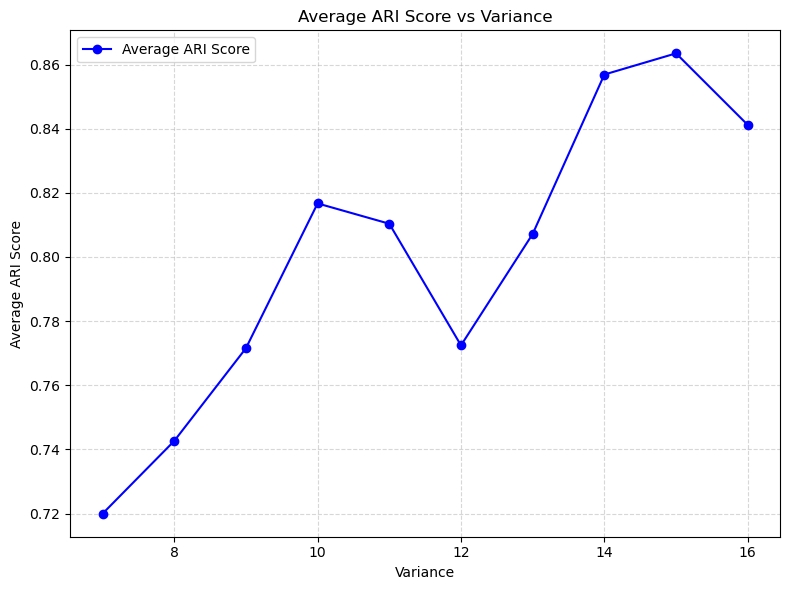

In [45]:
n_runs = 10
proposal_var = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
average_ari_scores = []
for v in tqdm(proposal_var): 
    ari_score = []
    for _ in range(n_runs):
        mh_predictions = metropolis_hastings(data, n_clusters, v)
        ari_score.append(adjusted_rand_score(labels, mh_predictions))
    average = sum(ari_score)/n_runs
    average_ari_scores.append(average)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(proposal_var, average_ari_scores, marker='o', linestyle='-', color='blue', label='Average ARI Score')

# Customize the plot
plt.title("Average ARI Score vs Variance")
plt.xlabel("Variance")
plt.ylabel("Average ARI Score")
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("Different_variances_test2.png")

# Display the plot
plt.show()

In [35]:
# Evaluate Clustering Results

# Assuming true_labels is a numpy array containing the true labels of the data points
# and kmeans_predictions, gibbs_predictions, mh_predictions are the predicted labels

# Calculate ARI for each clustering method
kmeans_ari = adjusted_rand_score(labels, kmeans_predictions)
gibbs_ari = adjusted_rand_score(labels, gibbs_predictions)
mh_ari = adjusted_rand_score(labels, mh_predictions)

# Print the ARI results
print("Adjusted Rand Index of Clustering Methods:")
print(f"K-Means ARI: {kmeans_ari:.2f}")
print(f"Gibbs Sampling ARI: {gibbs_ari:.2f}")
print(f"Metropolis-Hastings ARI: {mh_ari:.2f}")


Adjusted Rand Index of Clustering Methods:
K-Means ARI: 0.72
Gibbs Sampling ARI: 0.99
Metropolis-Hastings ARI: 0.86


In [36]:
# Compare Results
print("Comparison of Clustering Results:")
print("True labels", np.bincount(labels))
print("K-Means Predictions:", np.bincount(kmeans_predictions))
print("Gibbs Sampling Predictions:", np.bincount(gibbs_predictions))
print("Metropolis-Hastings Predictions:", np.bincount(mh_predictions))

Comparison of Clustering Results:
True labels [100 100 100 100 100 100 100 100 100 100]
K-Means Predictions: [ 87 130 130  68 117 112  72  83 102  99]
Gibbs Sampling Predictions: [100  98  99 100 100 102  99  99 103 100]
Metropolis-Hastings Predictions: [ 88 146 103 100  99 100  98 102 100  64]


In [42]:
import timeit
# How long each algorithm takes on average 
runs = 5

k_means_time = timeit.timeit("run_kmeans(data, n_clusters)", globals=globals(), number=runs)
gibbs_time = timeit.timeit("gibbs_sampling(data, n_clusters)", globals=globals(), number=runs)
mh_time = timeit.timeit("metropolis_hastings(data, n_clusters, 10)", globals=globals(), number=runs)

print(f"K-means clustering average time after {runs} runs: {k_means_time/runs:.4f} seconds")
print(f"Gibbs Sampling average time after {runs} runs: {gibbs_time/runs:.4f} seconds")
print(f"Metropolis-Hastings average time after {runs} runs: {mh_time/runs:.4f} seconds")

K-means clustering average time after 5 runs: 0.0159 seconds
Gibbs Sampling average time after 5 runs: 15.8722 seconds
Metropolis-Hastings average time after 5 runs: 137.0017 seconds


In [51]:
# Calculate the avergae perfromace after 10 runs 
n_runs = 10
proposal_var = [15]
average_ari_scores = []
for v in proposal_var: 
    ari_score = []
    for _ in range(n_runs):
        mh_predictions = metropolis_hastings(data, n_clusters, v)
        ari_score.append(adjusted_rand_score(labels, mh_predictions))
    average = sum(ari_score)/n_runs
    average_ari_scores.append(average)
    print(f" Variance: {v}, Average ARI: {average: .2f}, Max ARI: {np.max(ari_score): .2f}, Min ARI: {np.min(ari_score): .2f} ")

 Variance: 15, Average ARI:  0.80, Max ARI:  0.99, Min ARI:  0.57 


In [12]:
# Calculate the avergae perfromace after 10 runs when using a uniform proposal distribution
" NOTE! If you want run this you need to uncomment Optional proposal distribution in the metropolis-hasting function " 
n_runs = 10
n_clusters = len(pi)
ari_score = []
for _ in range(n_runs):
    mh_predictions = metropolis_hastings(data, n_clusters)
    ari_score.append(adjusted_rand_score(labels, mh_predictions))
average = sum(ari_score)/n_runs
print(f" Uniform Proposal Distribution, Average ARI: {average: .2f}, Max ARI: {np.max(ari_score): .2f}, Min ARI: {np.min(ari_score): .2f} ")

 Uniform Proposal Distribution, Average ARI:  0.90, Max ARI:  0.99, Min ARI:  0.85 
